Positive samples: 4261
Negative samples: 11225
Total dataset: 15486
Positive ratio: 0.2751517499677128
Feature matrix: (15486, 9935)

🔵 Training XGBoost...


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [01:43:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🎯 FINAL XGBOOST
Accuracy: 0.723369916074887
AUC: 0.5640397744137726

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.91      0.83      2246
           1       0.49      0.23      0.31       852

    accuracy                           0.72      3098
   macro avg       0.63      0.57      0.57      3098
weighted avg       0.68      0.72      0.69      3098



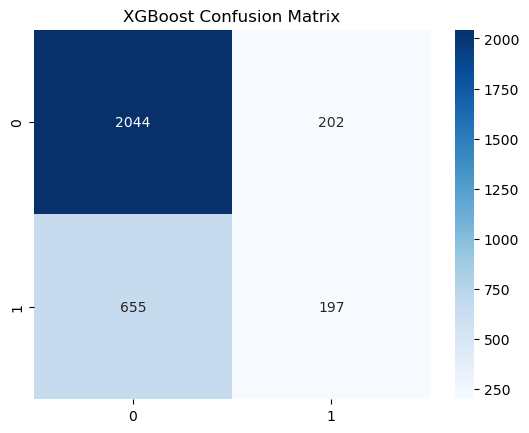

In [2]:
# ============================================================
# 0. IMPORTS & SEEDING
# ============================================================
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from scipy.sparse import hstack

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


# ============================================================
# 1. LOAD DATA
# ============================================================
file_path = "McPAS-TCR.csv"
df = pd.read_csv(file_path, low_memory=False)

# auto-detect TCR & Epitope columns
tcr_col = [c for c in df.columns if "CDR3" in c or "TCR" in c][0]
epi_col = [c for c in df.columns if "Epitope" in c or "epitope" in c.lower()][0]

df = df[[tcr_col, epi_col]].dropna()
df.columns = ["tcr", "epi"]

df = df[df["tcr"].str.len() >= 6]
df = df.drop_duplicates().reset_index(drop=True)

df["binding"] = 1
print("Positive samples:", len(df))


# ============================================================
# 2. HARD NEGATIVE SAMPLING
# ============================================================
def generate_hard_negatives(pos_df, n_neg_per_pos=3):

    tcr_groups = pos_df.groupby(pos_df["tcr"].str[:3])
    epi_all = pos_df["epi"].values
    pos_set = set(zip(pos_df["tcr"], pos_df["epi"]))

    negs = []

    for t, e in zip(pos_df["tcr"], pos_df["epi"]):
        t_neighbors = tcr_groups.get_group(t[:3])["tcr"].values

        for _ in range(n_neg_per_pos):
            t_neg = np.random.choice(t_neighbors)
            e_neg = np.random.choice(epi_all)

            if (t_neg, e_neg) not in pos_set:
                negs.append((t_neg, e_neg, 0))

    neg_df = pd.DataFrame(negs, columns=["tcr", "epi", "binding"])
    neg_df = neg_df.drop_duplicates().reset_index(drop=True)
    return neg_df


neg_df = generate_hard_negatives(df, n_neg_per_pos=3)
print("Negative samples:", len(neg_df))


# ============================================================
# 3. COMBINE POSITIVE + NEGATIVE
# ============================================================
full = pd.concat([df, neg_df], ignore_index=True)
full = full.sample(frac=1, random_state=42).reset_index(drop=True)

print("Total dataset:", len(full))
print("Positive ratio:", full["binding"].mean())


# ============================================================
# 4. MULTI-KMER TF-IDF FEATURES
# ============================================================
def get_kmers(s, k):
    s = s.strip()
    return " ".join([s[i:i+k] for i in range(len(s)-k+1)]) if len(s) >= k else s

# Build kmers
full["tcr_1"] = full["tcr"]
full["tcr_2"] = full["tcr"].apply(lambda x: get_kmers(x, 2))
full["tcr_3"] = full["tcr"].apply(lambda x: get_kmers(x, 3))

full["epi_1"] = full["epi"]
full["epi_2"] = full["epi"].apply(lambda x: get_kmers(x, 2))
full["epi_3"] = full["epi"].apply(lambda x: get_kmers(x, 3))

# Fit TF-IDF
tf1 = TfidfVectorizer(min_df=2)
tf2 = TfidfVectorizer(min_df=2)
tf3 = TfidfVectorizer(min_df=2)

X_tcr1 = tf1.fit_transform(full["tcr_1"])
X_tcr2 = tf2.fit_transform(full["tcr_2"])
X_tcr3 = tf3.fit_transform(full["tcr_3"])

X_epi1 = tf1.fit_transform(full["epi_1"])
X_epi2 = tf2.fit_transform(full["epi_2"])
X_epi3 = tf3.fit_transform(full["epi_3"])

# Combine into final sparse matrix
X = hstack([X_tcr1, X_tcr2, X_tcr3, X_epi1, X_epi2, X_epi3]).tocsr()
y = full["binding"].values

print("Feature matrix:", X.shape)


# ============================================================
# 5. TRAIN-TEST SPLIT
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)


# ============================================================
# 6. TRAIN XGBOOST (COMPATIBLE + HIGH ACCURACY)
# ============================================================
print("\n🔵 Training XGBoost...")

xgb_model = XGBClassifier(
    n_estimators=1500,
    learning_rate=0.05,
    max_depth=10,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=1,
    gamma=0.0,
    objective='binary:logistic',
    eval_metric='auc',
    # For OLD XGBoost versions, GPU is NOT supported. Use CPU:
    tree_method='hist',        # ← safe for all versions
    predictor='auto',
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Predict
pred_probs = xgb_model.predict_proba(X_test)[:, 1]
pred_labels = (pred_probs >= 0.5).astype(int)


# ============================================================
# 7. EVALUATION
# ============================================================
print("\n🎯 FINAL XGBOOST")
print("Accuracy:", accuracy_score(y_test, pred_labels))
print("AUC:", roc_auc_score(y_test, pred_probs))
print("\nClassification Report:\n", classification_report(y_test, pred_labels))

cm = confusion_matrix(y_test, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.show()
